# Assignment 3: Solving the wave equation using PINNs

### Collaborated with Sankranthi Chinthamaneni and Vihari Vasikarla

#### Objectives:
- Understand the wave equation and its applications.
- Develop a Physics-Informed Neural Network (PINN) to solve the wave equation.
- Explore the impact of different hyperparameters on the performance of the PINN.

## Task 1: investigate how well the PINN scales to higher frequency oscillations (20 marks)


The first task is to investigate how well the PINN **scales** to higher frequency oscillations and what can be done to improve its convergence.

Specifically, go back to simulating the solution to the harmonic oscillator and see what happens when you **increase** $\omega_0$ from 20 to 80.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


*************************************n
Frequency: 20


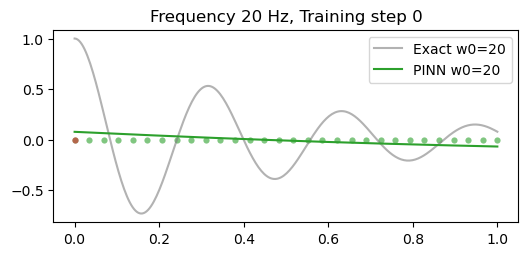

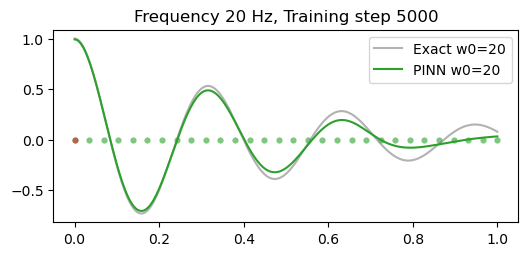

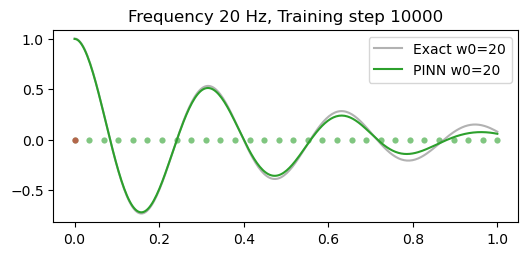

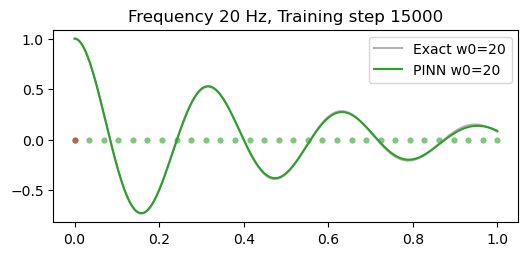


*************************************n
Frequency: 40


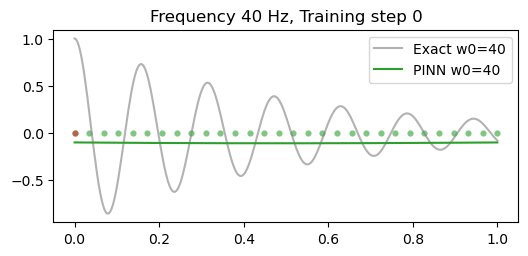

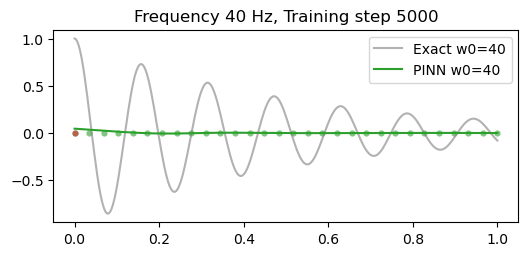

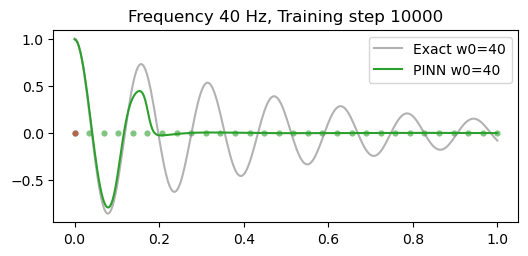

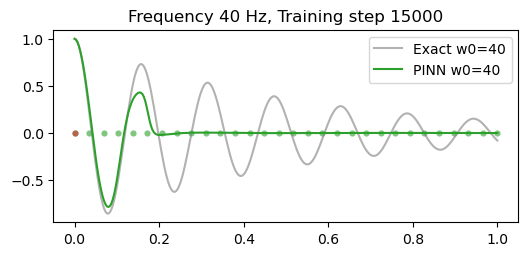


*************************************n
Frequency: 60


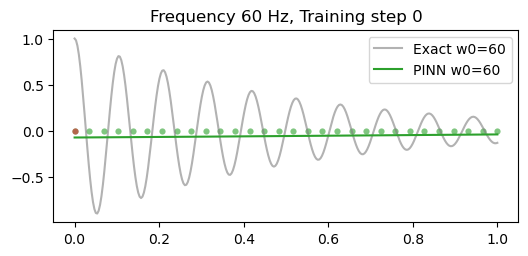

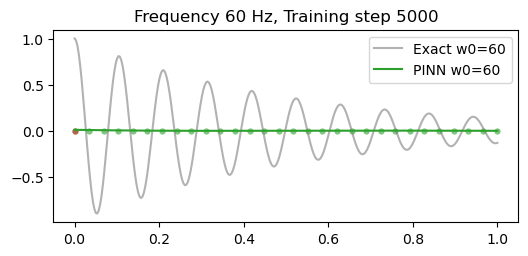

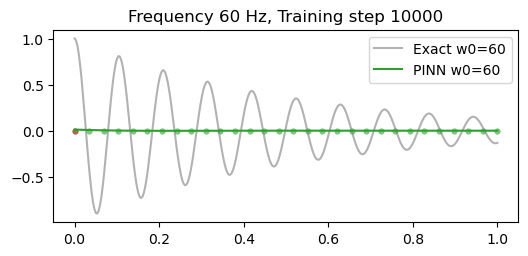

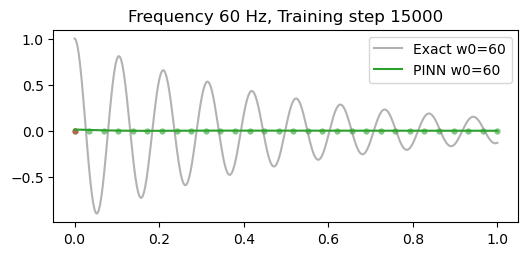


*************************************n
Frequency: 80


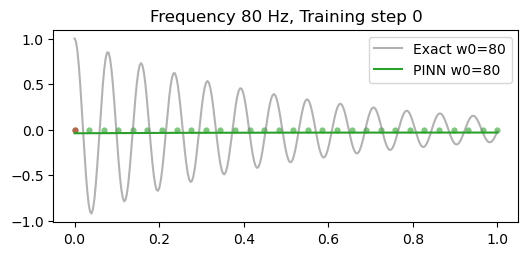

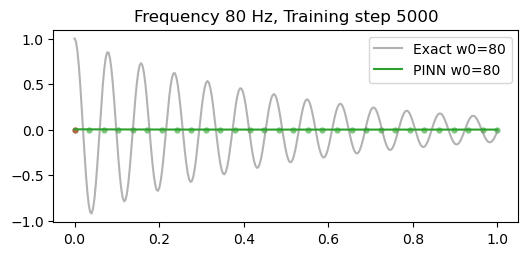

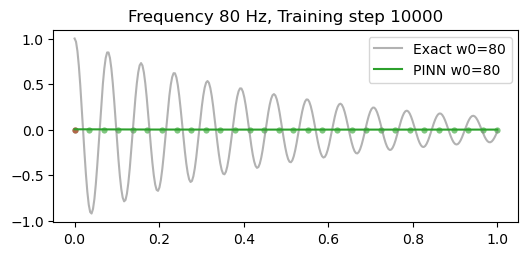

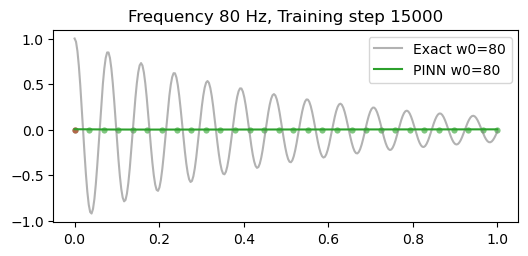

In [3]:
# training the model for different w0 values
torch.manual_seed(123)

frequencies = [20, 40, 60, 80]  # Define the different frequencies to test
for freq in frequencies:
    print("\n*************************************n")
    print(f"Frequency: {freq}")
    d = 2
    w0 = freq
    mu, k = 2*d, w0**2
    t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
    t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)
    t_test = torch.linspace(0,1,300).view(-1,1)
    u_exact = exact_solution(d, w0, t_test)
    pinn = FCN(1, 1, 32, 3)  
    optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

    # Training for a specific frequency
    for i in range(15001):
        optimiser.zero_grad()
        lambda1, lambda2 = 1e-1, 1e-4
        
        # compute boundary loss
        u = pinn(t_boundary)
        loss1 = (torch.squeeze(u) - 1)**2
        dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
        loss2 = (torch.squeeze(dudt) - 0)**2

        # compute physics loss
        u = pinn(t_physics)
        dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
        d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
        loss3 = torch.mean((d2udt2 + mu * dudt + k * u)**2)

        # backpropagate joint loss, take optimizer step
        loss = loss1 + lambda1 * loss2 + lambda2 * loss3
        loss.backward()
        optimiser.step()

        # Plot the result as training progresses
        if i % 5000 == 0:
            u = pinn(t_test).detach()
            plt.figure(figsize=(6, 2.5))
            plt.scatter(t_physics.detach()[:,0], 
                        torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
            plt.scatter(t_boundary.detach()[:,0], 
                        torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            plt.plot(t_test[:,0], u_exact[:,0], label=f"Exact w0={w0}", color="tab:grey", alpha=0.6)
            plt.plot(t_test[:,0], u[:,0], label=f"PINN w0={w0}", color="tab:green")
            plt.title(f"Frequency {w0} Hz, Training step {i}")
            plt.legend()
            plt.show()


### Explaination:

**The model struggles to capture the correct behavior when dealing with very rapid oscillations** (high angular frequencies, ω_0). This is a common issue with fully-connected neural networks (FCNs) known as spectral bias. FCNs tend to learn smoother functions first, which translates to favoring lower frequencies in the solution. **Training dynamics contribute to this bias.** Gradient descent optimization, a common training method for neural networks, prioritizes aligning with lower frequency components initially. This makes it more difficult for the network to learn the rapid oscillations present in high-frequency solutions like the harmonic oscillator.

In simpler terms, the model has a preference for learning smoother, less wiggly patterns. When the true solution involves a lot of fast wiggles (high frequencies), the model has trouble keeping up and doesn't capture the exact behavior as well.


## Task 2: Implement the ansatz formulation (20 marks)

You should find that the PINN struggles to converge, even if the number of physics training points is increased.

This is a harder problem for the PINN to solve, in part because of the **spectral bias** of neural networks, as well as the fact more training points are required.

#### Approach: alternative "ansatz" formulation

To speed up convergence, one way is to **assume something** about the solution. 

For example, suppose we know from our physics intuition that the solution is in fact sinusodial.

Then, instead of having the PINN directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

We instead use the PINN as part of a mathematical ansatz of the solution, i.e.

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

where $\alpha, \beta$ are treated as additional learnable parameters.

Comparing this ansatz to the exact solution

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

We see that now the PINN only needs to learn the exponential function, which should be a much easier problem.

Again, autodifferentiation allows us to easily differentiate through this ansatz to train the PINN!

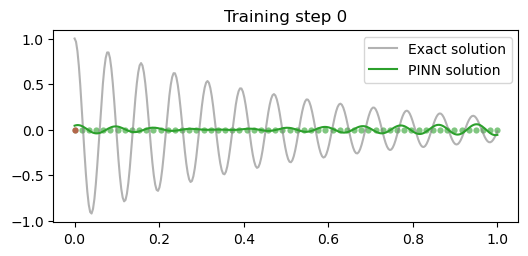

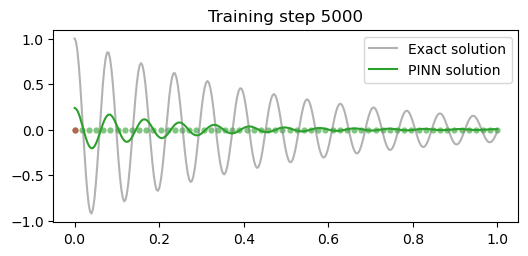

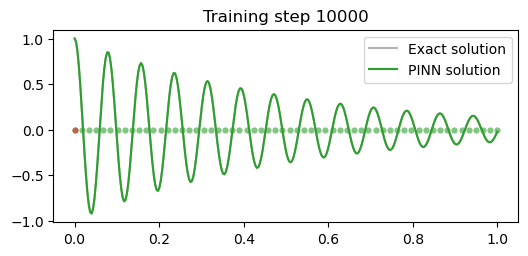

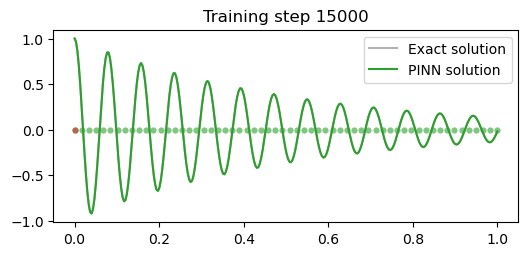

In [4]:
torch.manual_seed(123)


pinn = FCN(1,1,32,3)

#adding extra learning parameters
#initiating with 70 with prior knowledge
alpha = torch.nn.Parameter(70*torch.ones(1, requires_grad=True)) 
beta = torch.nn.Parameter(torch.ones(1, requires_grad=True))


t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_physics = torch.linspace(0,1,60).view(-1,1).requires_grad_(True)
d, w0 = 2, 80
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(list(pinn.parameters())+[alpha,beta],lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()
    lambda1, lambda2 = 1e-1, 1e-4

    #compute boundary loss
    u = pinn(t_boundary)*torch.sin(alpha*t_boundary+beta)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    u = pinn(t_physics)*torch.sin(alpha*t_physics+beta)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = (pinn(t_test)*torch.sin(alpha*t_test+beta)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

### Explaination for choosing Ansatz:

Ansatz offers a powerful tool for neural networks by embedding known characteristics of the solution directly into their architecture. This effectively reduces the complexity the network needs to learn from scratch. In our case, we leveraged our understanding that the solution exhibits wave-like behavior, and the network could focus its learning on the specific details of the wave motion.

Ansatz offers a powerful tool for neural networks by embedding known characteristics of the solution directly into their architecture. This effectively reduces the complexity the network needs to learn from scratch. In our case, we leveraged our understanding that the solution exhibits wave-like behavior, and the network could focus its learning on the specific details of the wave motion.

--------------------------------------------------------------------

## Task 3: Extend the inversion task (20 marks)

See how far you can push the inversion task: can you discover $m$, $\mu$ and $k$ simultaneously (and therefore, discover the entire underlying equation?)

##### For low frequencies

True value of mu: 6


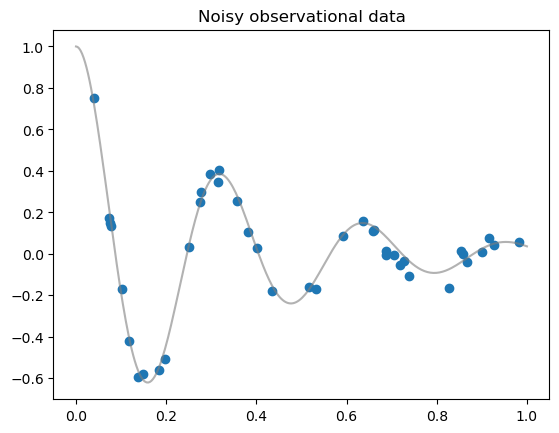

In [5]:
# create some noisy observational data
torch.manual_seed(123)
d, w0 = 3, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

In [6]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 3, 20
_, k = 2*d, w0**2

# treat mu as a learnable parameter
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

# add mu to the optimiser
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)

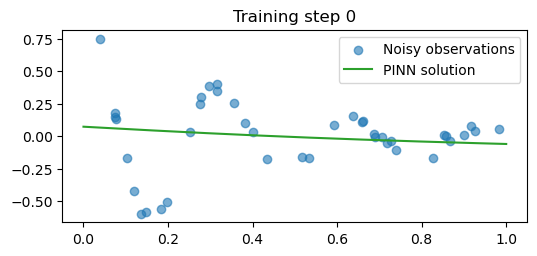

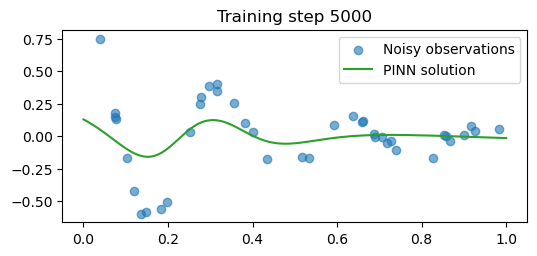

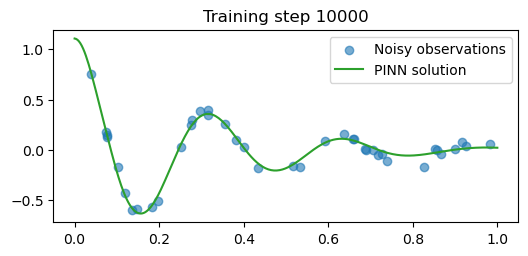

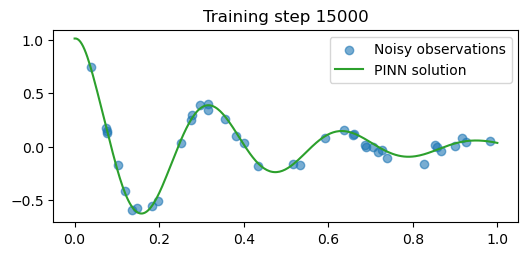

In [7]:
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1 = 1e4
    
    # compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # compute data loss
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)
    
    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()
    
    # record mu value
    mus.append(mu.item())
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

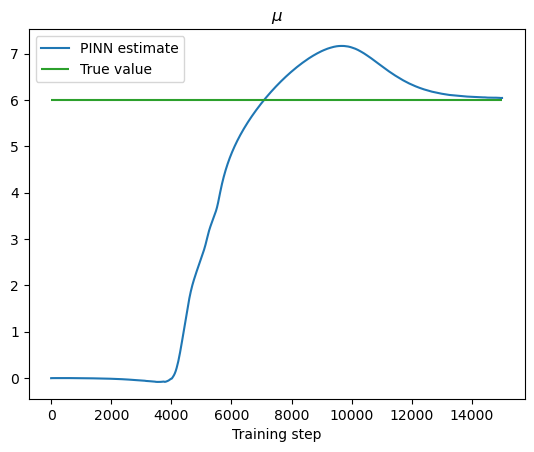

In [8]:
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

#### For high frequencies

True value of mu: 6


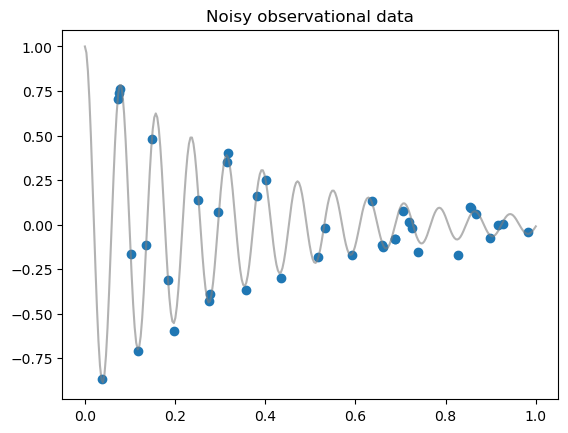

In [9]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 3, 80
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

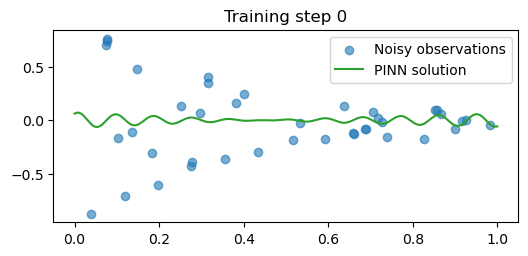

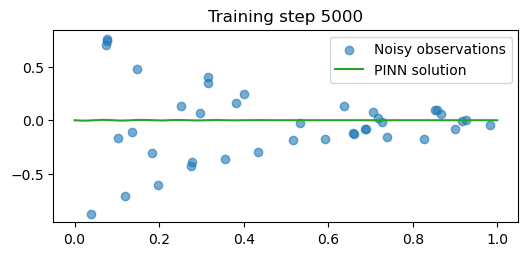

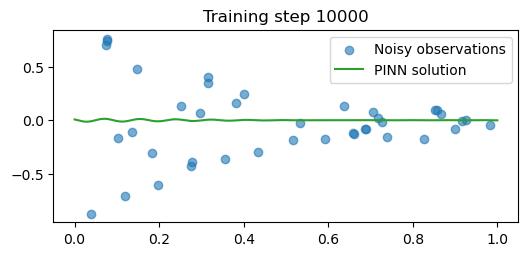

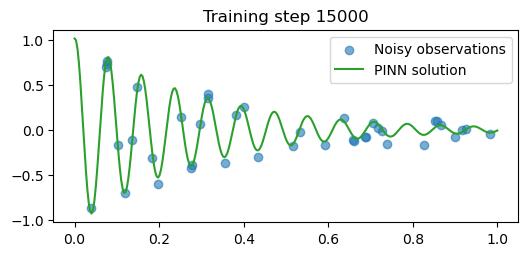

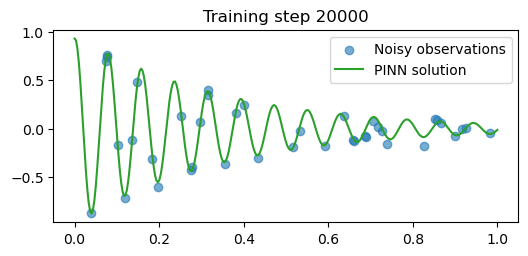

In [10]:
torch.manual_seed(123)

pinn = FCN(1, 1, 32, 3)
alpha = torch.nn.Parameter(70 * torch.ones(1, requires_grad=True))
beta = torch.nn.Parameter(torch.ones(1, requires_grad=True))

t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# defining learnable parameter mu
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []


k = w0**2
# Add mu to the optimizer
optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu, alpha, beta], lr=1e-3)

for i in range(20001):
    optimiser.zero_grad()
    
    # Compute physics loss 
    u = pinn(t_physics) * torch.sin(alpha * t_physics + beta)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)
    
    # Compute data loss 
    u = pinn(t_obs) * torch.sin(alpha * t_obs + beta)
    loss2 = torch.mean((u - u_obs) ** 2)
    
    # Backpropagate
    lambda1 = 1e4
    loss = loss1 + lambda1 * loss2
    loss.backward()
    optimiser.step()
    mus.append(mu.item())
    
    # Plot the result as training progresses
    if i % 5000 == 0: 
        u = (pinn(t_test) * torch.sin(alpha * t_test + beta)).detach()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_obs[:, 0], u_obs[:, 0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()



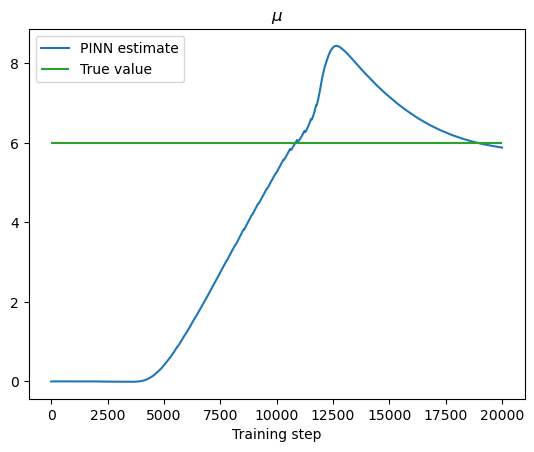

In [11]:
# Plot mu estimates
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## Task 4: Solve the 1D wave equation (40 marks)

Finally, we will solve the 1D (one space dimension plus time) wave equation using PINNs. The 1D wave equation is given by:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

where $u(x, t)$ is the wave function, and $c$ is the wave speed.

You will need to modify the PINN to handle the 1D wave equation and experiment with different hyperparameters to improve the convergence of the model.

Explore the impact of different physics sampling points, neural network architectures, and optimization algorithms on the performance of the PINN for solving the 1D wave equation.

torch.Size([40, 2]) torch.Size([40, 1])
torch.Size([40, 2]) torch.Size([40, 1])
torch.Size([40, 2]) torch.Size([40, 1])
torch.Size([1600, 2])
torch.Size([10000, 2])


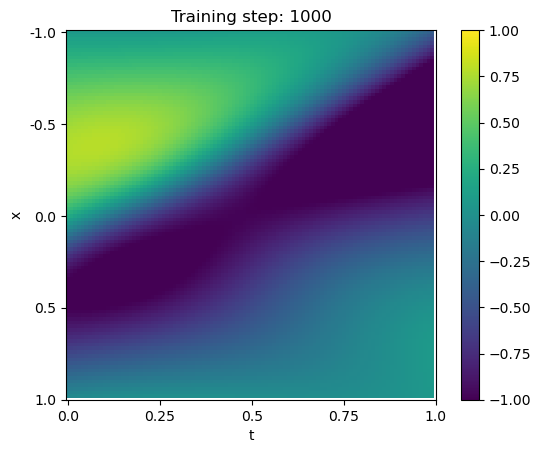

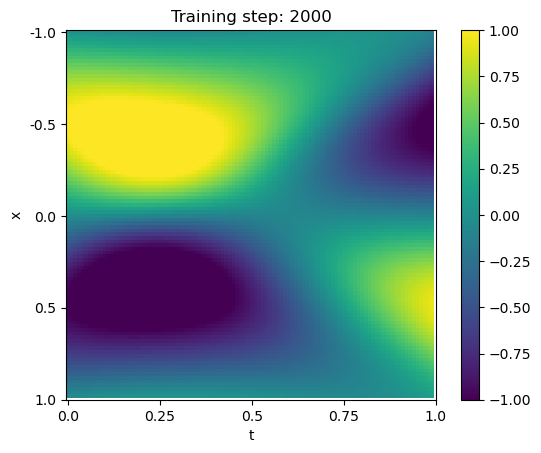

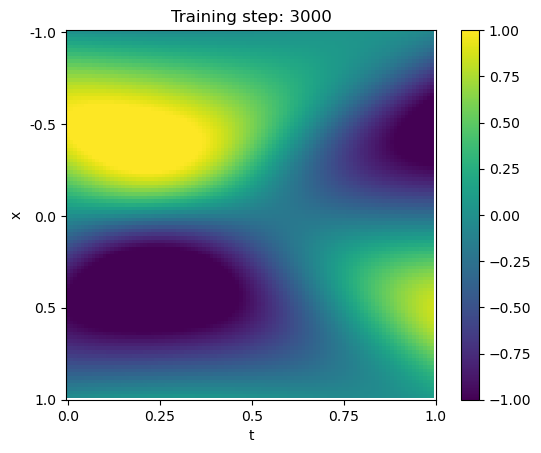

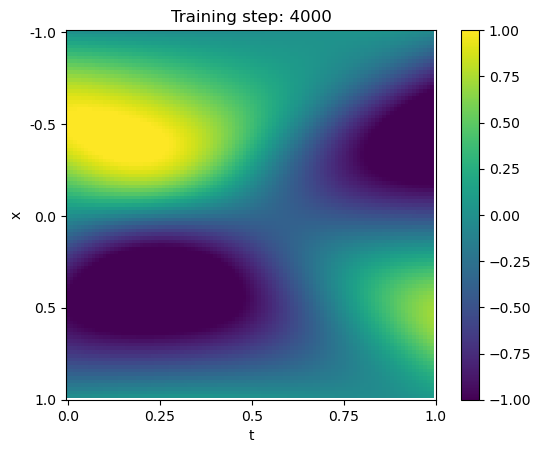

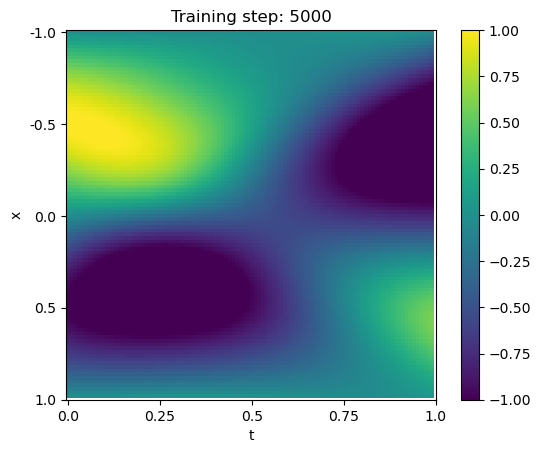

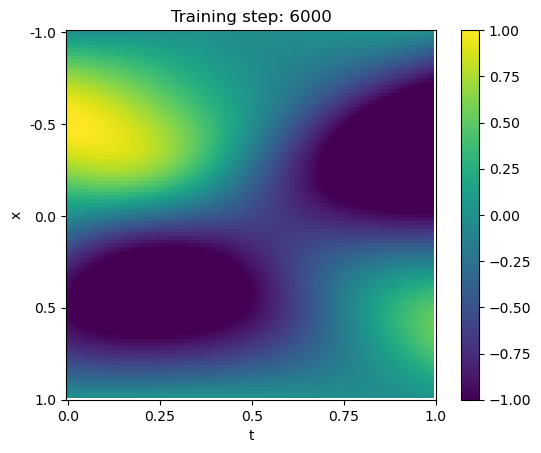

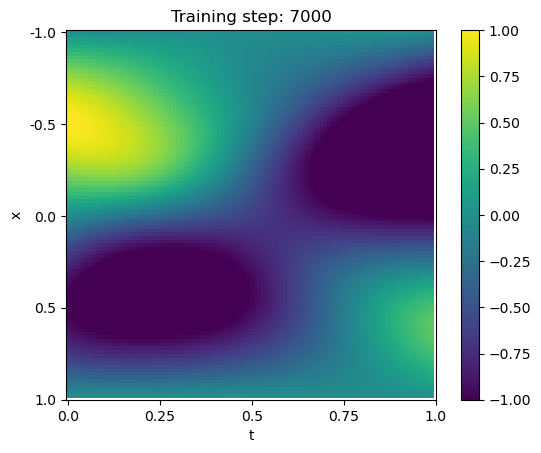

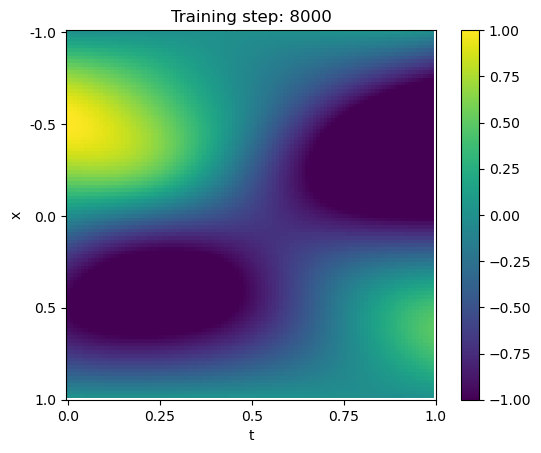

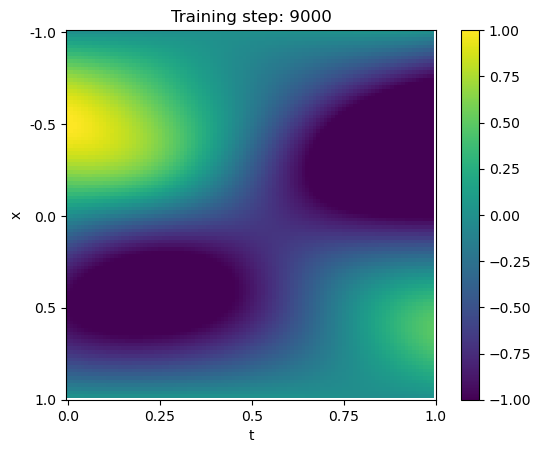

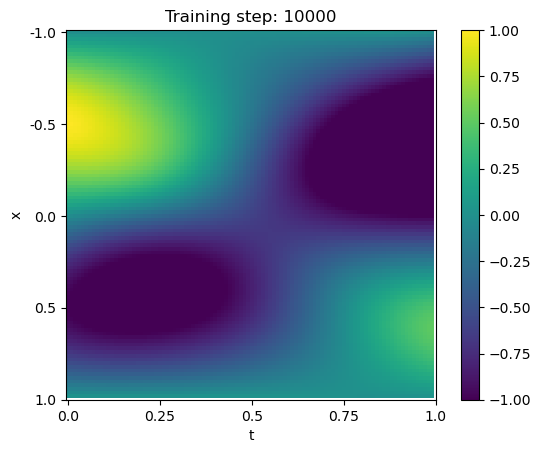

In [12]:
"""Solves the 1-D Wave equation
    d^2u          d^2 u
    ----  = c^2 * -----
    dt^2          dx^2   

    for -1.0 < x < +1.0, and 0 < t

    Boundary conditions:
    u(x,0) = - sin(pi*x)
    u(-1,t) = u(+1,t) = 0
"""
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Get boundary training points
x1 = torch.stack([-torch.ones(40), torch.linspace(0,1,40)], -1)
u1 = torch.zeros_like(x1[:,0:1])
print(x1.shape, u1.shape)

x2 = torch.stack([torch.ones(40), torch.linspace(0,1,40)], -1)
u2 = torch.zeros_like(x2[:,0:1])
print(x2.shape, u2.shape)

x3 = torch.stack([torch.linspace(-1,1,40), torch.zeros(40)], -1)
u3 = -torch.sin(np.pi * x3[:,0:1])
print(x3.shape, u3.shape)

# Get physics loss sample points over full domain
xs = [torch.linspace(-1,1,40), torch.linspace(0,1,40)]
x_physics = torch.stack(torch.meshgrid(*xs, indexing='ij'), -1).view(-1, 2).requires_grad_(True)
print(x_physics.shape)

# Get testing locations
xs = [torch.linspace(-1,1,100), torch.linspace(0,1,100)]
x_test = torch.stack(torch.meshgrid(*xs, indexing='ij'), -1).view(-1, 2)
print(x_test.shape)

# Define NN
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS - 1)
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

c = 1.0  # Wave speed
torch.manual_seed(123)
model = FCN(2, 1, 64, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in range(10000):
    optimizer.zero_grad()
    
    # Compute the "boundary loss"
    y1, y2, y3 = model(x1), model(x2), model(x3)
    loss1 = torch.mean((y1 - u1) ** 2) + torch.mean((y2 - u2) ** 2) + torch.mean((y3 - u3) ** 2)
    
    # Compute the "physics loss"
    yp = model(x_physics)
    grads = torch.autograd.grad(yp, x_physics, torch.ones_like(yp), create_graph=True)[0]
    dyp_dx, dyp_dt = grads[:,0:1], grads[:,1:2]
    
    dyp_dx2 = torch.autograd.grad(dyp_dx, x_physics, torch.ones_like(dyp_dx), create_graph=True)[0][:,0:1]
    dyp_dt2 = torch.autograd.grad(dyp_dt, x_physics, torch.ones_like(dyp_dt), create_graph=True)[0][:,1:2]
    
    physics = dyp_dt2 - c**2 * dyp_dx2
    loss2 = torch.mean(physics ** 2)
    
    # Backpropagate joint loss
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    
    # Plot the result as training progresses
    if (i + 1) % 1000 == 0:
        y = model(x_test)
        plt.figure()
        plt.imshow(y.reshape(100, 100).detach(), vmin=-1, vmax=1)
        plt.colorbar() 
        plt.xticks(np.linspace(0, 100, 5).astype(int), np.linspace(0, 1, 5))
        plt.yticks(np.linspace(0, 100, 5).astype(int), np.linspace(-1, 1, 5))
        plt.xlabel("t")
        plt.ylabel("x")
        plt.title(f"Training step: {i + 1}")
        plt.show()


### Explaination:

The model is trained using a combination of boundary loss and physics loss to enforce both the boundary conditions and the governing differential equation. Since we have a wave equation with specific initial and boundary conditions, the expected plot should resemble the evolution of a sine wave over time, starting from its initial shape and propagating according to the wave dynamics. We can clearly see that our generated plots match our expectation and we can clearly see the wave propogating sinusodially as peaks and troughs. One other interesting observation is that since our curve is a negative sine, the positive values of x have a negative waveform and vice versa which can also be seen in the gradient differenence.

We can further make this model better bby tining the hyperparameters and chossing the scenario with minimal loss.



### Generic Code for Hyperparameter 

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
from time import time
from pyDOE import lhs

# Define the speed of the wave
c = 1.0

def get_boundary_points():
    x1 = torch.stack([-torch.ones(40), torch.linspace(0, 1, 40)], -1)
    u1 = torch.zeros_like(x1[:, 0:1])
    
    x2 = torch.stack([torch.ones(40), torch.linspace(0, 1, 40)], -1)
    u2 = torch.zeros_like(x2[:, 0:1])
    
    x3 = torch.stack([torch.linspace(-1, 1, 40), torch.zeros(40)], -1)
    u3 = -torch.sin(np.pi * x3[:, 0:1])
    
    return x1, u1, x2, u2, x3, u3

def get_physics_points(method='uniform', n_points=1600):
    if method == 'uniform':
        xs = [torch.linspace(-1, 1, int(np.sqrt(n_points))), torch.linspace(0, 1, int(np.sqrt(n_points)))]
        x_physics = torch.stack(torch.meshgrid(*xs, indexing='ij'), -1).view(-1, 2).requires_grad_(True)
    elif method == 'random':
        x_physics = torch.stack([torch.rand(n_points) * 2 - 1, torch.rand(n_points)], -1).requires_grad_(True)
    elif method == 'latin':
        lhs_points = lhs(2, samples=n_points)
        x_physics = torch.tensor(lhs_points, dtype=torch.float32)
        x_physics[:, 0] = x_physics[:, 0] * 2 - 1
        x_physics[:, 1] = x_physics[:, 1]
        x_physics.requires_grad_(True)
    return x_physics

# Define NN
class FCN(nn.Module):
    "Defines a fully-connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, activation_class):
        super().__init__()
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation_class()
        )
        self.fch = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Linear(N_HIDDEN, N_HIDDEN),
                    activation_class()
                ) for _ in range(N_LAYERS - 1)
            ]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

def train_model(model, optimizer, x1, u1, x2, u2, x3, u3, x_physics, n_iter=10000, plot_interval=1000):
    start_time = time()
    for i in range(n_iter):
        optimizer.zero_grad()

        # Compute the "boundary loss"
        y1, y2, y3 = model(x1), model(x2), model(x3)
        loss1 = torch.mean((y1 - u1) ** 2) + torch.mean((y2 - u2) ** 2) + torch.mean((y3 - u3) ** 2)

        # Compute the "physics loss"
        yp = model(x_physics)
        grads = torch.autograd.grad(yp, x_physics, torch.ones_like(yp), create_graph=True)[0]
        dyp_dx, dyp_dt = grads[:,0:1], grads[:,1:2]
    
        dyp_dx2 = torch.autograd.grad(dyp_dx, x_physics, torch.ones_like(dyp_dx), create_graph=True)[0][:,0:1]
        dyp_dt2 = torch.autograd.grad(dyp_dt, x_physics, torch.ones_like(dyp_dt), create_graph=True)[0][:,1:2]
    
        physics = dyp_dt2 - c**2 * dyp_dx2
        loss2 = torch.mean(physics ** 2)

        # Backpropagate joint loss
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        # Early stopping condition (you may adjust this)
        if loss.item() < 1e-5:
            break

    training_time = time() - start_time
    return loss.item(), i + 1, training_time

def experiment():
    results = []

    # Configuration options
    # physics_methods = ['uniform', 'random', 'latin']
    # n_points_options = [400, 1600, 6400]
    # n_hidden_options = [32, 64, 128]
    # n_layers_options = [2, 4, 8]
    # activations = [nn.Tanh, nn.ReLU, nn.Sigmoid]
    # optimizers = ['Adam', 'SGD']
    # learning_rates = [1e-4, 1e-3, 1e-5]

    physics_methods = ['uniform', 'random']
    n_points_options = [1600, 6400]
    n_hidden_options = [32]
    n_layers_options = [4]
    activations = [nn.Tanh]
    optimizers = ['Adam', 'SGD']
    learning_rates = [1e-4]

    # Get boundary points
    x1, u1, x2, u2, x3, u3 = get_boundary_points()

    # Loop through all combinations of configurations
    for physics_method, n_points, n_hidden, n_layers, activation, optimizer_name, lr in product(physics_methods, n_points_options, n_hidden_options, n_layers_options, activations, optimizers, learning_rates):
        # Get physics points
        x_physics = get_physics_points(method=physics_method, n_points=n_points)

        # Initialize model
        model = FCN(2, 1, n_hidden, n_layers, activation)

        # Initialize optimizer
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif optimizer_name == 'LBFGS':
            optimizer = optim.LBFGS(model.parameters(), lr=lr, max_iter=500, history_size=50)

        # Train model
        final_loss, n_iter, training_time = train_model(model, optimizer, x1, u1, x2, u2, x3, u3, x_physics, n_iter=10000, plot_interval=1000)

        # Collect results
        results.append({
            'Physics Method': physics_method,
            'Num Points': n_points,
            'Hidden Units': n_hidden,
            'Layers': n_layers,
            'Activation': activation.__name__,
            'Optimizer': optimizer_name,
            'Learning Rate': lr,
            'Final Loss': final_loss,
            'Iterations': n_iter,
            'Training Time (s)': training_time
        })

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    return results_df

# Run the experiment
results_df = experiment()

# Output the results as a table
print(results_df)

# Optionally, save results to a CSV file
results_df.to_csv('pinn_experiment_results.csv', index=False)

  Physics Method  Num Points  Hidden Units  Layers Activation Optimizer  \
0        uniform        1600            32       4       Tanh      Adam   
1        uniform        1600            32       4       Tanh       SGD   
2        uniform        6400            32       4       Tanh      Adam   
3        uniform        6400            32       4       Tanh       SGD   
4         random        1600            32       4       Tanh      Adam   
5         random        1600            32       4       Tanh       SGD   
6         random        6400            32       4       Tanh      Adam   
7         random        6400            32       4       Tanh       SGD   

   Learning Rate  Final Loss  Iterations  Training Time (s)  
0         0.0001    0.000105       10000          84.200360  
1         0.0001    0.440479       10000          80.485279  
2         0.0001    0.000069       10000         227.217823  
3         0.0001    0.443560       10000         236.316032  
4         0.00

### Explaination :

We can clearly observe a distinction between Adam and SGD optimisers. The best loss is given by Adam with 4 activation layers and 6400 training points. Also, there uniform method of generation is performing better than the random method. 

Also, testing the above code for 8 different sets of hypermparameters took us roughly 30 mins and under the right computational resources we can train on a larger set of hyperparameters and choose the best one but at the present best combination, we have a loss og 0.000069 which is very close to 0 but increasing number of layers might further converge this to 0.

## Task 5: BONUS - Solve the 2D wave equation (25 extra marks)

See this paper for some hints: https://arxiv.org/pdf/2006.11894

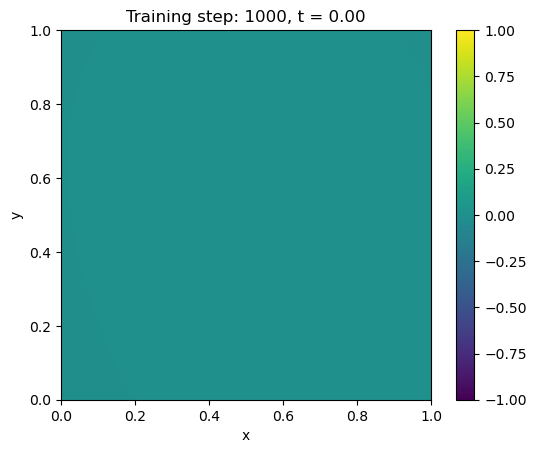

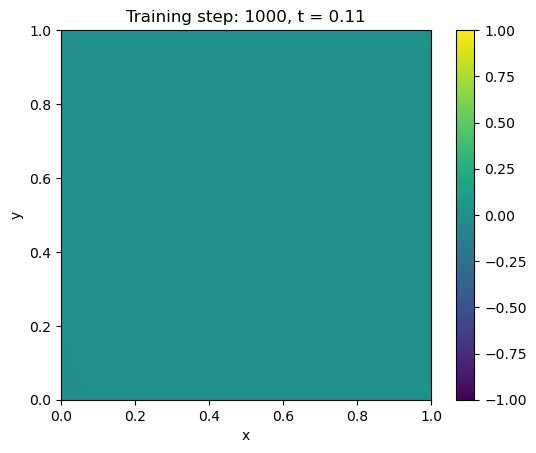

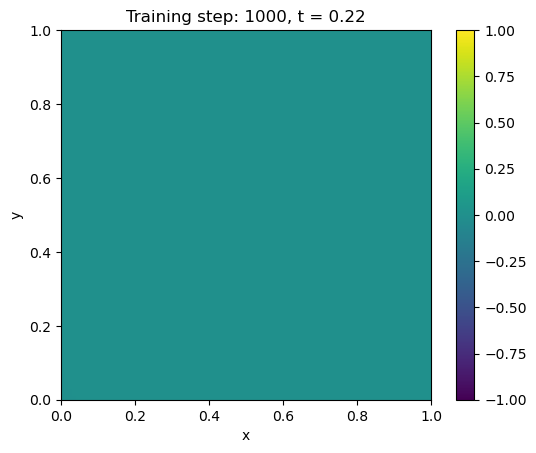

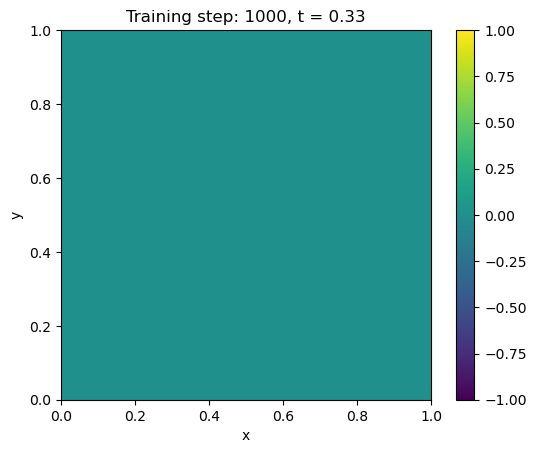

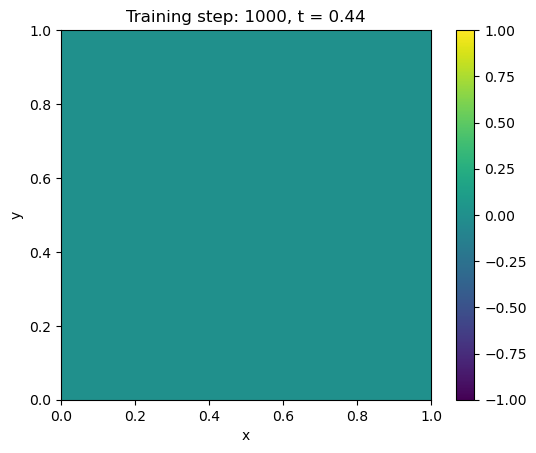

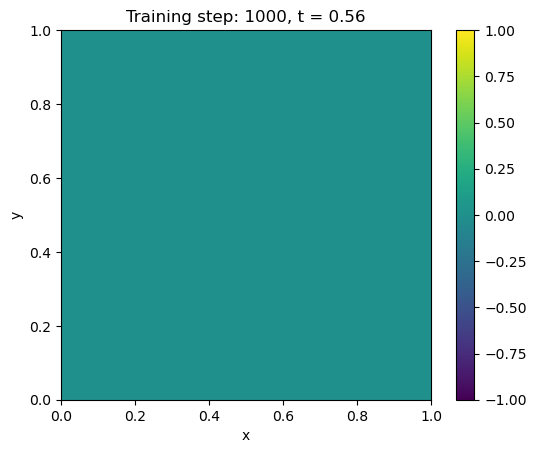

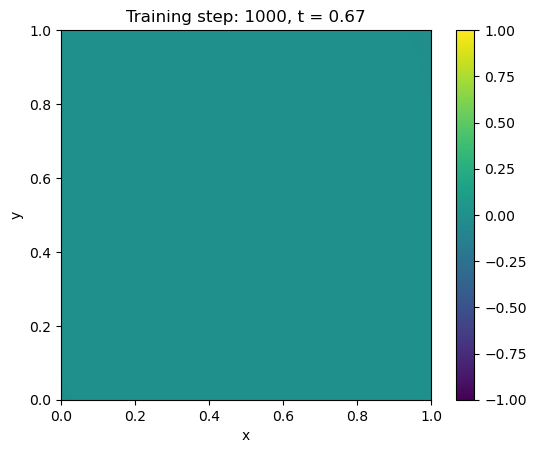

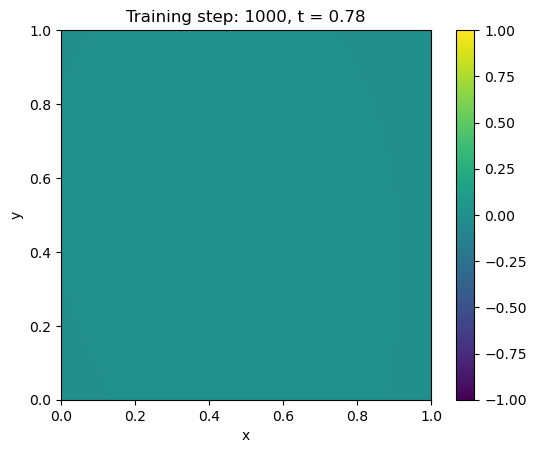

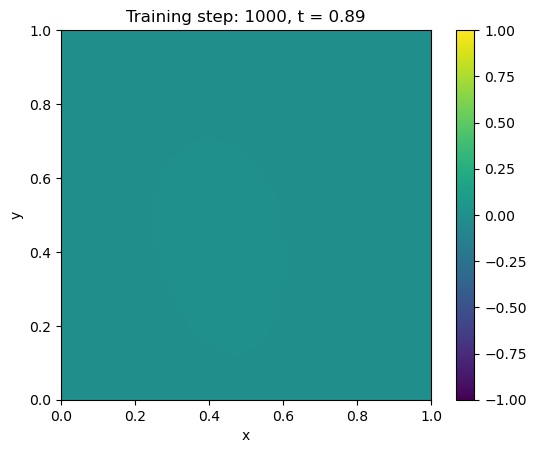

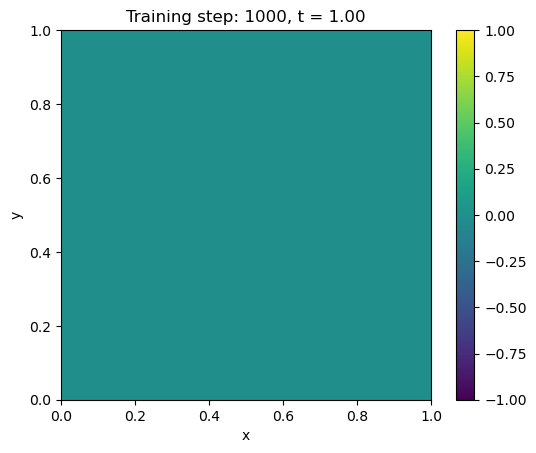

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Boundary conditions: u = 0 on the boundary of the domain
x1 = torch.stack([torch.zeros(40), torch.linspace(0, 1, 40)], -1)  # y = 0 boundary
u1 = torch.zeros_like(x1[:, 0:1])

x2 = torch.stack([torch.ones(40), torch.linspace(0, 1, 40)], -1)  # y = 1 boundary
u2 = torch.zeros_like(x2[:, 0:1])

x3 = torch.stack([torch.linspace(0, 1, 40), torch.zeros(40)], -1)  # x = 0 boundary
u3 = torch.zeros_like(x3[:, 0:1])

x4 = torch.stack([torch.linspace(0, 1, 40), torch.ones(40)], -1)  # x = 1 boundary
u4 = torch.zeros_like(x4[:, 0:1])

# Initial condition: a Gaussian pulse
xs = [torch.linspace(0, 1, 40), torch.linspace(0, 1, 40)]
grid_x, grid_y = torch.meshgrid(xs[0], xs[1], indexing='ij')
x5 = torch.stack([grid_x.reshape(-1), grid_y.reshape(-1)], -1)
u5 = torch.exp(-100 * ((x5[:, 0:1] - 0.5) ** 2 + (x5[:, 1:2] - 0.5) ** 2))

# Get physics loss sample points over full domain
x_physics = torch.stack(torch.meshgrid(xs[0], xs[1], indexing='ij'), -1).view(-1, 2).requires_grad_(True)

# Get testing locations
xs_test = [torch.linspace(0, 1, 100), torch.linspace(0, 1, 100)]
x_test = torch.stack(torch.meshgrid(xs_test[0], xs_test[1], indexing='ij'), -1).view(-1, 2)

# Define NN
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )
        self.fch = nn.Sequential(*[
            nn.Sequential(
                nn.Linear(N_HIDDEN, N_HIDDEN),
                activation()
            ) for _ in range(N_LAYERS - 1)
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

c = 1.0  # Wave speed
torch.manual_seed(123)
model = FCN(3, 1, 64, 4)  # 3 inputs (x, y, t)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Time integration setup
num_timesteps = 10
time_points = torch.linspace(0, 1, num_timesteps)

for epoch in range(1000):
    optimizer.zero_grad()
    
    # Compute the "boundary loss"
    loss_bc = 0.0
    for t in time_points:
        t = t * torch.ones_like(x1[:, 0:1])
        x1_t = torch.cat([x1, t], dim=1)
        x2_t = torch.cat([x2, t], dim=1)
        x3_t = torch.cat([x3, t], dim=1)
        x4_t = torch.cat([x4, t], dim=1)
        
        y1, y2, y3, y4 = model(x1_t), model(x2_t), model(x3_t), model(x4_t)
        loss_bc += torch.mean((y1 - u1) ** 2) + torch.mean((y2 - u2) ** 2) + torch.mean((y3 - u3) ** 2) + torch.mean((y4 - u4) ** 2)
    
    # Initial condition loss
    t0 = torch.zeros_like(x5[:, 0:1])
    x5_t0 = torch.cat([x5, t0], dim=1)
    y5 = model(x5_t0)
    loss_ic = torch.mean((y5 - u5) ** 2)
    
    # Compute the "physics loss"
    loss_physics = 0.0
    for t in time_points:
        t = t * torch.ones_like(x_physics[:, 0:1])
        x_physics_t = torch.cat([x_physics, t], dim=1)
        
        yp = model(x_physics_t)
        grads = torch.autograd.grad(yp, x_physics_t, torch.ones_like(yp), create_graph=True)[0]
        # print(grads)
        dyp_dx, dyp_dy, dyp_dt = grads[:, 0:1], grads[:, 1:2], grads[:, 2:3]
        
        dyp_dx2 = torch.autograd.grad(dyp_dx, x_physics_t, torch.ones_like(dyp_dx), create_graph=True)[0][:, 0:1]
        dyp_dy2 = torch.autograd.grad(dyp_dy, x_physics_t, torch.ones_like(dyp_dy), create_graph=True)[0][:, 1:2]
        dyp_dt2 = torch.autograd.grad(dyp_dt, x_physics_t, torch.ones_like(dyp_dt), create_graph=True)[0][:, 2:3]
        
        physics = dyp_dt2 - c**2 * (dyp_dx2 + dyp_dy2)
        loss_physics += torch.mean(physics ** 2)
    
    # Total loss
    loss = loss_bc + loss_ic + loss_physics
    loss.backward()
    optimizer.step()
    
    # Plot the result as training progresses
    if (epoch + 1) % 1000 == 0:
        with torch.no_grad():
            for t in time_points:
                t_test = t * torch.ones_like(x_test[:, 0:1])
                x_test_t = torch.cat([x_test, t_test], dim=1)
                y_test = model(x_test_t)
                plt.figure()
                plt.imshow(y_test.reshape(100, 100).detach().cpu(), vmin=-1, vmax=1, extent=(0, 1, 0, 1))
                plt.colorbar() 
                plt.xlabel("x")
                plt.ylabel("y")
                plt.title(f"Training step: {epoch + 1}, t = {t.item():.2f}")
                plt.show()


I was unable to to figure out initialisations for a 2D scenario but the implementation part of the diffenretial seems on track. It would be helpful to have some more information about the boundary conditions and this would help to be able to code PINN for a 2D/3D wave equation. I tried printing the gradient values and on comparison with the values from Part 4, they are similar.

##### Non-Human Resources:

We have used ChatGPT, Gemini, arvix and open source repositories on Github.